# Starter Code for the Lesson 13: PCA

## Faces recognition example using eigenfaces and SVMs

The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

  .. _LFW: http://vis-www.cs.umass.edu/lfw/

original source: http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html

In [1]:
from time import time
import logging

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

import matplotlib.pyplot as plt

### Display progress logs on stdout

In [4]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

## Download the data, if not already on disk and load it as numpy arrays

In [7]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

2021-08-12 17:11:02,287 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976012
2021-08-12 17:11:04,791 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976009
2021-08-12 17:11:06,860 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976006
2021-08-12 17:11:09,453 Downloading LFW data (~200MB): https://ndownloader.figshare.com/files/5976015


## Introspect the images arrays to find the shapes (for plotting)

In [8]:
n_samples, h, w = lfw_people.images.shape
np.random.seed(42)

# for machine learning we use the data directly (as relative pixel
# position info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print(f"n_samples: {n_samples}")
print(f"n_features: {n_features}")
print(f"n_classes: {n_classes}")

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


## Split into a training and testing set

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled dataset): unsupervised feature extraction / dimensionality reduction

In [15]:
n_components = 10

print(f"Extracting the top {n_components} eigenfaces from {X_train.shape[0]} faces")
t0 = time()
pca = PCA(n_components=n_components, whiten=True).fit(X_train)

print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")

t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print("done in %0.3fs" % (time() - t0))

Extracting the top 10 eigenfaces from 966 faces
done in 0.055s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.006s


## Train a SVM classification model

In [16]:
print("Fitting the classifier to the training set")

t0 = time()
param_grid = {
    'C': [1e3, 5e3, 1e4, 5e4, 1e5],
    'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
}

# For sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)

print("Done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
Done in 66.038s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.1)


## Quantitative evaluation of the model quality on the test set

In [17]:
print("Predicting the people names on the testing set")

t0 = time()
y_pred = clf.predict(X_test_pca)
print("Done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting the people names on the testing set
Done in 0.055s
                   precision    recall  f1-score   support

     Ariel Sharon       0.10      0.15      0.12        13
     Colin Powell       0.43      0.53      0.48        60
  Donald Rumsfeld       0.26      0.33      0.30        27
    George W Bush       0.66      0.58      0.62       146
Gerhard Schroeder       0.17      0.20      0.18        25
      Hugo Chavez       0.25      0.13      0.17        15
       Tony Blair       0.50      0.39      0.44        36

         accuracy                           0.46       322
        macro avg       0.34      0.33      0.33       322
     weighted avg       0.49      0.46      0.47       322

[[ 2  6  1  3  1  0  0]
 [ 8 32  2 10  4  1  3]
 [ 2  9  9  5  1  0  1]
 [ 7 21 10 84 14  3  7]
 [ 0  1  4 10  5  2  3]
 [ 1  2  2  8  0  2  0]
 [ 1  3  6  7  5  0 14]]


## Qualitative evaluation of the predictions using matplotlib 

IndexError: index 10 is out of bounds for axis 0 with size 10

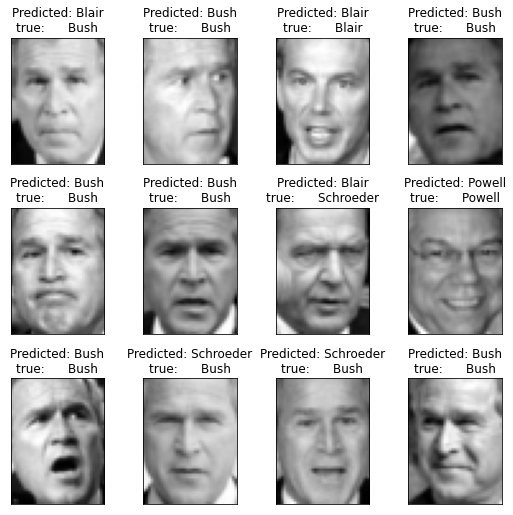

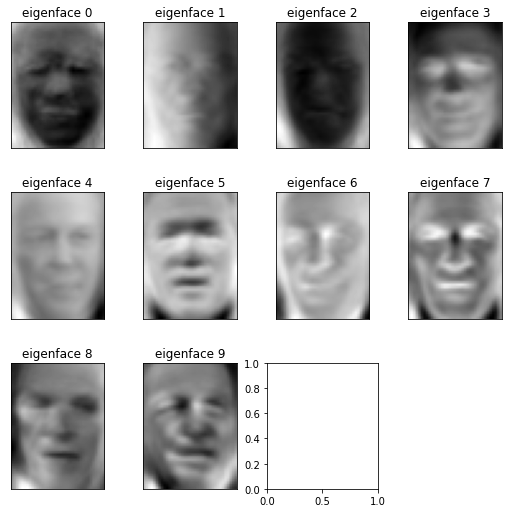

In [18]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits.
    """
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)

    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# Plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return f'Predicted: {pred_name}\ntrue:      {true_name}'

prediction_titles = [title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# Plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

In [14]:
pca.explained_variance_ratio_

array([0.19346525, 0.15116838, 0.07083668, 0.059518  , 0.051575  ,
       0.02887153, 0.02514483, 0.02176463, 0.02019379, 0.01902122,
       0.01682208, 0.01580598, 0.01223363, 0.01087937, 0.01064452,
       0.00979653, 0.00892398, 0.00854845, 0.00835711, 0.00722636,
       0.00696569, 0.00653856, 0.00639558, 0.00561317, 0.00531107,
       0.00520152, 0.00507465, 0.00484209, 0.00443588, 0.00417829,
       0.00393704, 0.00381728, 0.00356061, 0.00351201, 0.00334556,
       0.0032993 , 0.00314626, 0.00296217, 0.00290136, 0.00284723,
       0.00280004, 0.00267556, 0.00259901, 0.00258401, 0.00240919,
       0.00238994, 0.00235403, 0.00222587, 0.00217508, 0.00216566,
       0.00209064, 0.00205426, 0.00200421, 0.00197395, 0.0019383 ,
       0.00188764, 0.00180173, 0.00178897, 0.00174819, 0.00173054,
       0.00165647, 0.00162948, 0.00157409, 0.00153429, 0.00149965,
       0.00147262, 0.00143931, 0.00141882, 0.00139697, 0.00138147,
       0.00134005, 0.00133169, 0.00128812, 0.00125595, 0.00124